# U-net: Convolutional networks for biomedical image segmentation

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)


    The U-Net architecture is built upon the Fully Convolutional Network and modified in a way that it yields better segmentation in medical imaging. Compared to FCN-8, the two main differences are (1) U-net is symmetric and (2) the skip connections between the downsampling path and the upsampling path apply a concatenation operator instead of a sum. These skip connections intend to provide local information to the global information while upsampling. Because of its symmetry, the network has a large number of feature maps in the upsampling path, which allows to transfer information. By comparison, the basic FCN architecture only had number of classes feature maps in its upsampling path.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files

In [2]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

--2019-03-25 06:53:58--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  94.4MB/s    in 7.9s    

2019-03-25 06:54:06 (95.2 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2019-03-25 06:54:07--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  75.7MB/s    in 0.2s    

2019-03-25 06:54:07 (75.7 MB/s)

Note that we have two folders. The first one is images which contains the raw images and annotation which contains the masks as a binary folder image.

### Generators

In [0]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  '''
  Image generator
  '''  
  while True: 
    
    # extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    # variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:

        # get the masks. Note that masks are png files 
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))


        # preprocess the mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        # preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        # check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    # preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)

In [0]:
batch_size = 32

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

# split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [0]:
x, y = next(train_generator)

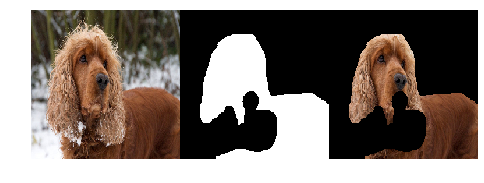

In [6]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

### Jaccard metric of Intersection over Union

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $x_{true}, x_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

The jaccard is a per class evaluation metric, which computes the number of pixels in the intersection between the predicted and ground truth segmentation maps for a given class, divided by the number of pixels in the union between those two segmentation maps, also for that given class.

In [0]:
def mean_iou(y_true, y_pred):
  '''
  IoU metric
  '''
  yt0 = y_true[:,:,:,0]
  yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')

  inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
  union = tf.count_nonzero(tf.add(yt0, yp0))

  iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    
  return iou

# U-net Model

In [0]:
def unet(sz = (256, 256, 3)):
  '''
  U-net model architecture
  '''
  x = Input(sz)
  inputs = x
  
  # down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  # bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  # upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  # classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  # model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [9]:
model = unet()

Instructions for updating:
Colocations handled automatically by placer.


### Callbacks

Simple functions to save the model at each epoch and show some predictions.


In [0]:
def build_callbacks():
  '''
  Callback for model check point stored in file
  '''
  checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
  callbacks = [checkpointer, PlotLearning()]
   
  return callbacks

In [0]:
# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
      
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
      
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',
              logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),
              'val_mean_iou=',logs.get('val_mean_iou'))
        
        # choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        # predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        # mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        # show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

### Training

Instructions for updating:
Use tf.cast instead.
i= 1 loss= 0.5581802921752407 val_loss= 0.502179354429245 mean_iou= 0.17698252930719333 val_mean_iou= 0.45241946523839777


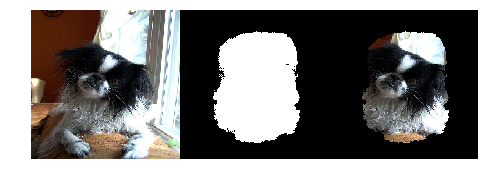

i= 2 loss= 0.4530433616409563 val_loss= 0.45795656605200336 mean_iou= 0.42637152049996674 val_mean_iou= 0.36032204736362805


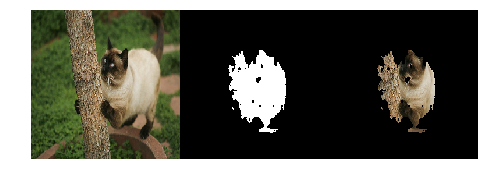

i= 3 loss= 0.43276081414527545 val_loss= 0.40918994491750543 mean_iou= 0.46097174749526804 val_mean_iou= 0.4770889228040522


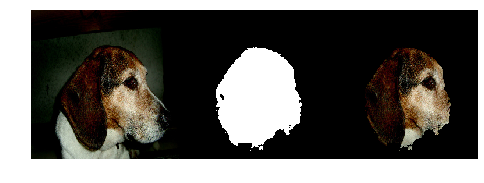

i= 4 loss= 0.40908041868579986 val_loss= 0.37707105008038605 mean_iou= 0.5023296829908406 val_mean_iou= 0.4655394337394021


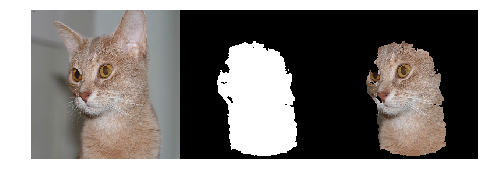

i= 5 loss= 0.366402302022394 val_loss= 0.3604176369580356 mean_iou= 0.5563983141559444 val_mean_iou= 0.5915684591640126


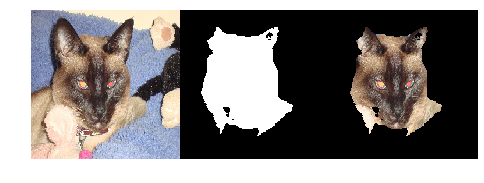

i= 6 loss= 0.3286330946232086 val_loss= 0.3576651080088182 mean_iou= 0.6097543256603963 val_mean_iou= 0.6288673660971902


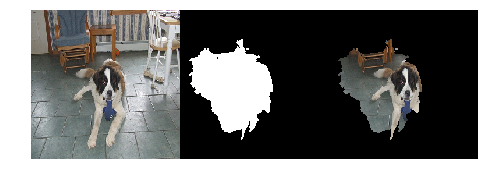

i= 7 loss= 0.2977840188023162 val_loss= 0.3190656060522253 mean_iou= 0.6431697817970085 val_mean_iou= 0.5983950170603666


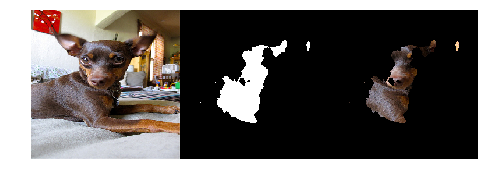

i= 8 loss= 0.2683463123835385 val_loss= 0.25218691473657434 mean_iou= 0.6746027668317159 val_mean_iou= 0.6947212652726606


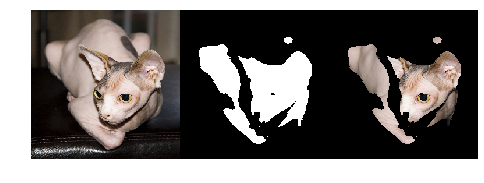

i= 9 loss= 0.2532865992283712 val_loss= 0.25634893774986267 mean_iou= 0.6990248849402824 val_mean_iou= 0.7200543772090565


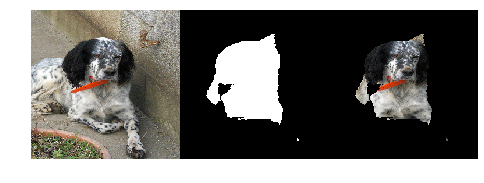

i= 10 loss= 0.23638747979516853 val_loss= 0.2908150011842901 mean_iou= 0.7202134306572344 val_mean_iou= 0.6349407813765786


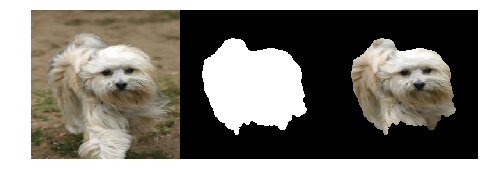

i= 11 loss= 0.2179803938762238 val_loss= 0.20881608264012771 mean_iou= 0.7377310332642298 val_mean_iou= 0.7447508085857738


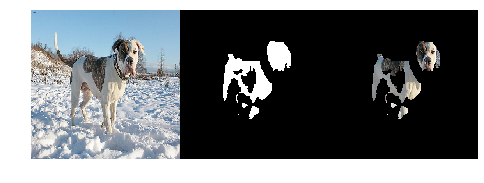

i= 12 loss= 0.20493563295227207 val_loss= 0.23592092232270676 mean_iou= 0.7517682586086395 val_mean_iou= 0.7402742396701466


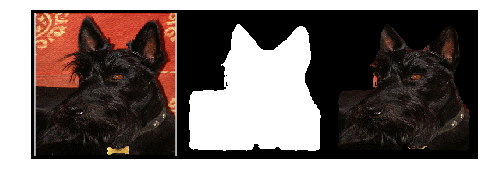

i= 13 loss= 0.19172957546362593 val_loss= 0.23216463219035754 mean_iou= 0.7652916951810933 val_mean_iou= 0.7209754965522073


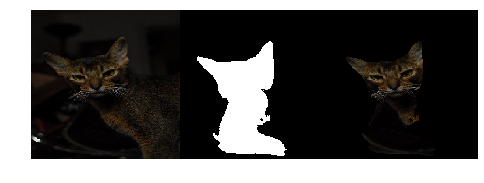

i= 14 loss= 0.18027228484415028 val_loss= 0.23224662786180322 mean_iou= 0.7793941323615644 val_mean_iou= 0.7500987269661643


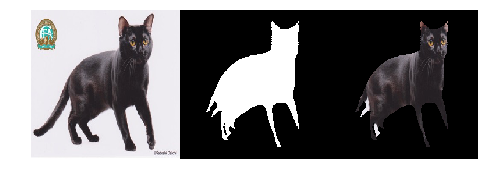

i= 15 loss= 0.1709290456418033 val_loss= 0.30713505907492206 mean_iou= 0.7921912084975743 val_mean_iou= 0.7137995687398043


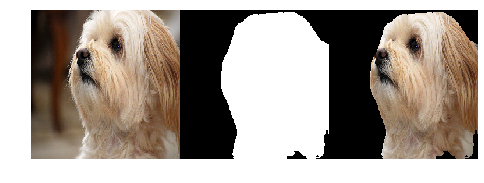

i= 16 loss= 0.16226515061643026 val_loss= 0.22863058339465747 mean_iou= 0.800425824781531 val_mean_iou= 0.7448258074847135


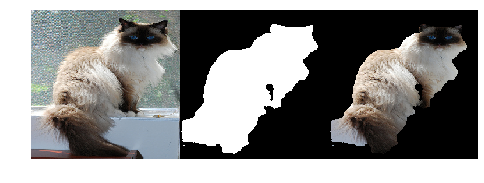

i= 17 loss= 0.15122756314332084 val_loss= 0.2278674691915512 mean_iou= 0.8133577519355843 val_mean_iou= 0.7501621354709972


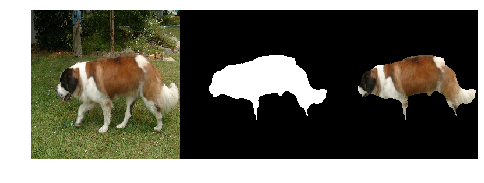

i= 18 loss= 0.1472232079124886 val_loss= 0.2670141133395108 mean_iou= 0.8178792601306689 val_mean_iou= 0.7192138270898298


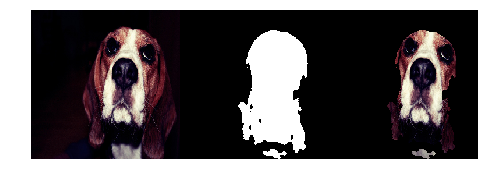

i= 19 loss= 0.13865465459894372 val_loss= 0.20463852855292233 mean_iou= 0.827970576885084 val_mean_iou= 0.775191995230588


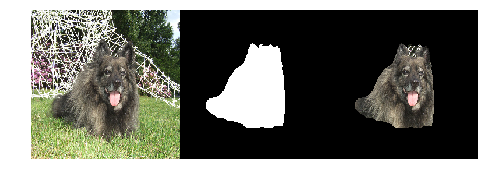

i= 20 loss= 0.1320855535872995 val_loss= 0.19438912245360288 mean_iou= 0.8357189093550591 val_mean_iou= 0.7749349203976718


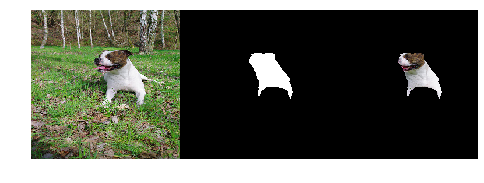

i= 21 loss= 0.12790782290370498 val_loss= 0.2325889833948829 mean_iou= 0.8396853883516843 val_mean_iou= 0.7501259717074308


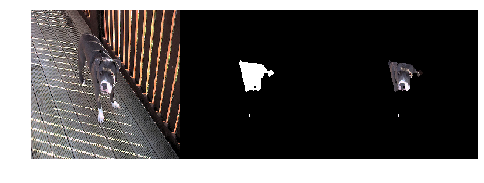

i= 22 loss= 0.12195593435062121 val_loss= 0.2795310359109532 mean_iou= 0.8476988493579708 val_mean_iou= 0.7484825036742471


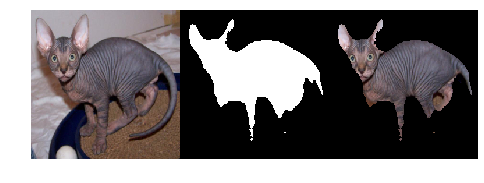

i= 23 loss= 0.11768794634706897 val_loss= 0.24852042306553235 mean_iou= 0.8524060428959049 val_mean_iou= 0.7705977559089661


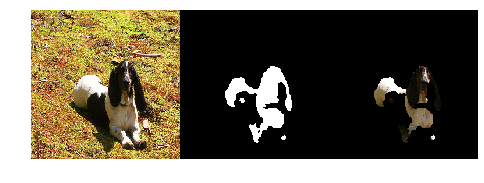

i= 24 loss= 0.11456251368947225 val_loss= 0.240965951572765 mean_iou= 0.8571184391844763 val_mean_iou= 0.7536004185676575


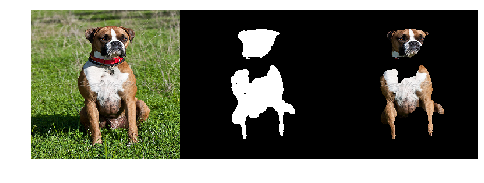

i= 25 loss= 0.11034998998522214 val_loss= 0.24623219804330307 mean_iou= 0.8590286273390191 val_mean_iou= 0.7579005468975414


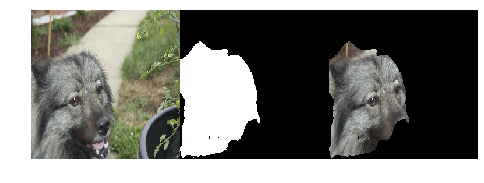

i= 26 loss= 0.10609848841548511 val_loss= 0.291810158978809 mean_iou= 0.8663874796536415 val_mean_iou= 0.7525769634680315


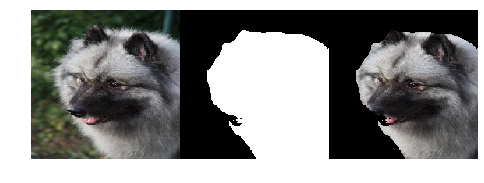

i= 27 loss= 0.10265011360792264 val_loss= 0.24357936057177457 mean_iou= 0.8687639263666929 val_mean_iou= 0.7650249925526705


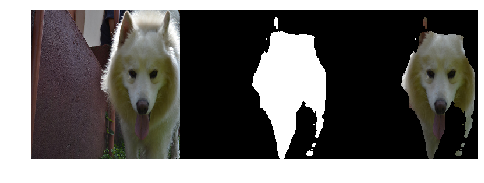

i= 28 loss= 0.09973434943994974 val_loss= 0.22832224585793234 mean_iou= 0.8726089253817519 val_mean_iou= 0.7622279741547324


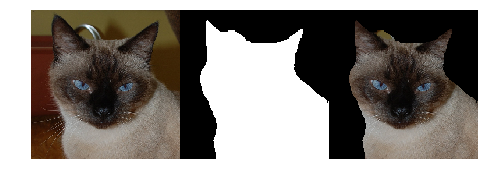

i= 29 loss= 0.09800812006677122 val_loss= 0.2951518188823353 mean_iou= 0.8746030836889188 val_mean_iou= 0.7397446740757335


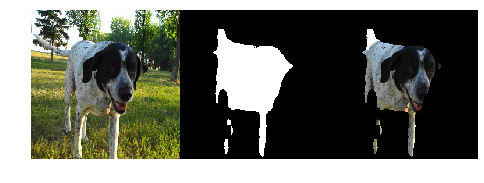

i= 30 loss= 0.09289311835346702 val_loss= 0.3142052103172649 mean_iou= 0.8796912037074294 val_mean_iou= 0.7552775090390985


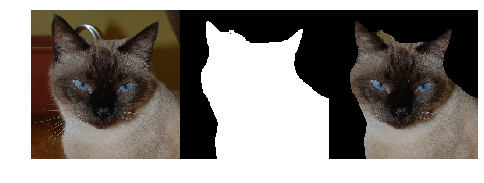

CPU times: user 59min 30s, sys: 9min 25s, total: 1h 8min 56s
Wall time: 41min 13s


In [12]:
%%time
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size

model.fit_generator(train_generator, 
                    epochs = 30, 
                    steps_per_epoch = train_steps,
                    validation_data = test_generator, 
                    validation_steps = test_steps,
                    callbacks = build_callbacks(), 
                    verbose = 0)

In [13]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2019-03-25 07:39:49--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 13.35.198.120, 13.35.198.86, 13.35.198.6, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|13.35.198.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K   408KB/s    in 0.2s    

2019-03-25 07:39:50 (408 KB/s) - ‘test.jpg’ saved [63219/63219]



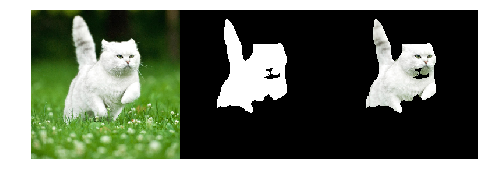

In [14]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

# predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

# mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

# show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet
